In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('jedinstveni.csv')
df.drop(columns=['Broj sedišta'], inplace=True)
df.drop(columns=['Boja enterijera'], inplace=True)
df = df.drop('Strana volana', axis=1)
df = df.drop('Stanje', axis=1)

In [95]:
"""
Iz skupa su izbačene kolone kao što su broj sjedišta, strana vilana i stanje. jer Č strana volana je uvijek lijeva, stanje je uvijek polovno a 
broj sjedišta je 5.
"""

'\nIz skupa su izbačene kolone kao što su broj sjedišta, strana vilana i stanje. jer Č strana volana je uvijek lijeva, stanje je uvijek polovno a \nbroj sjedišta je 5.\n'

In [96]:
#Koliko imamo nedostajucih vrednosti po svakoj koloni, bar chart da plotujemo za kolone koje imaju 0
#markdown celije: uredni
# df.isnull().sum()

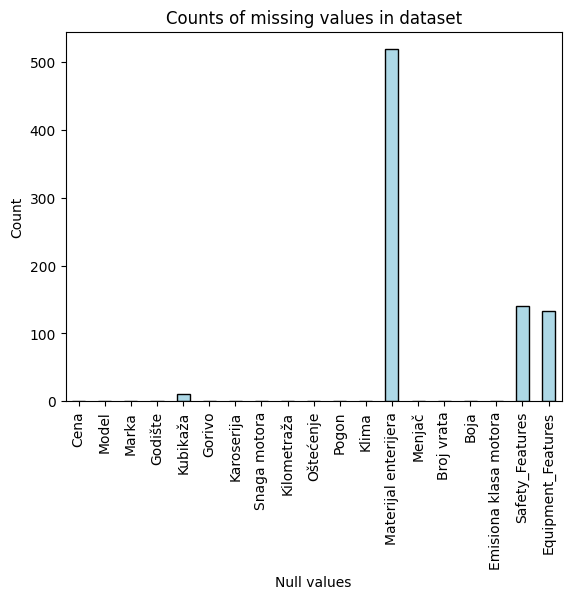

In [97]:
#vizualizacija nedostajucih vrednosti po kolonama. -----barchart bi znacio. ako su redudantne vizualizacije. u sto manje vremena
#da ga prodjemo u roku od 5 minuta i da je sve jasno sta se desava
import seaborn as seab
# seab.heatmap(df.isnull(),cbar=False,cmap='viridis')

df.isnull().sum().plot(kind='bar', color='lightblue', edgecolor='black') #da logaritmujemo count kad imamo nesrazmijerne grafike
plt.title('Counts of missing values in dataset')
plt.xlabel('Null values')
plt.ylabel('Count')
plt.show()

146     NaN
556     NaN
1787    NaN
2577    NaN
2649    NaN
2775    NaN
2962    NaN
2979    NaN
3075    NaN
3093    NaN
Name: Kubikaža, dtype: object 146     Električni pogon
556     Električni pogon
1787    Električni pogon
2577    Električni pogon
2649    Električni pogon
2775    Električni pogon
2962    Električni pogon
2979    Električni pogon
3075    Električni pogon
3093    Električni pogon
Name: Gorivo, dtype: object


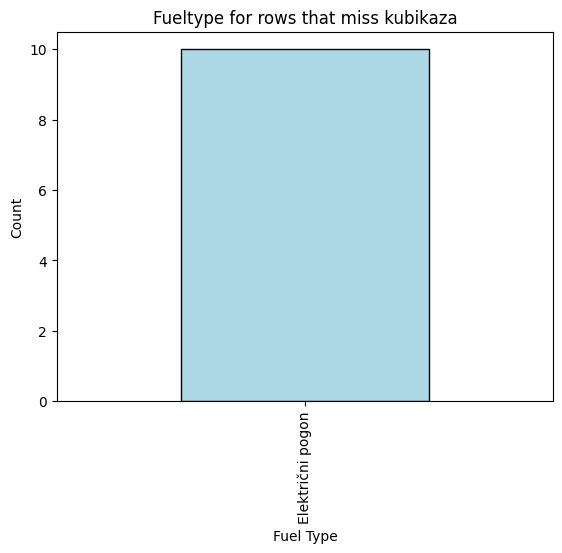

In [98]:
"""OVO STAVITI U EDA NOTEBOOK"""
missing_rows = df[df['Kubikaža'].isnull()]
# print(missing_rows)
print(missing_rows['Kubikaža'], missing_rows['Gorivo'])
missing_rows['Gorivo'].value_counts().plot(kind='bar', color='lightblue', edgecolor='black') #da logaritmujemo count kad imamo nesrazmijerne grafike
plt.title('Fueltype for rows that miss kubikaza')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.show()

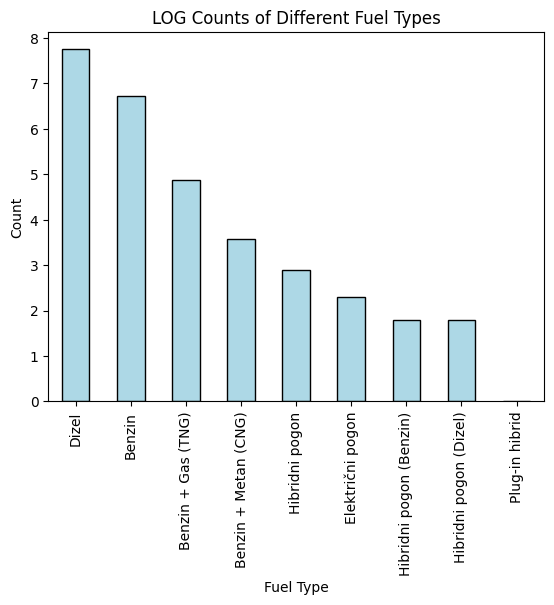

In [99]:

df['Gorivo'].value_counts()
np.log(df['Gorivo'].value_counts()).plot(kind='bar', color='lightblue', edgecolor='black') 
plt.title('LOG Counts of Different Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.show()

In [100]:
#Zakljucujemo da ne zelimo da radimo sa elektricnim i hibridnim vozililma jer ih ima ukupno 41 (premalo)
#Benzin u kombiniciji sa TNG i CNG cemo spojiti u jednu kategoriju -- ovo u markdown celiju
def categorize_fuel(value):
    if value == 'Dizel':
        return 'Dizel'
    elif value == 'Benzin':
        return 'Benzin'
    elif value in ['Benzin + Gas (TNG)', 'Benzin + Metan (CNG)']:
        return 'Gas'
    else:
        return 'Other'

df['Gorivo'] = df['Gorivo'].apply(categorize_fuel)

df = df[df['Gorivo'] != 'Other']

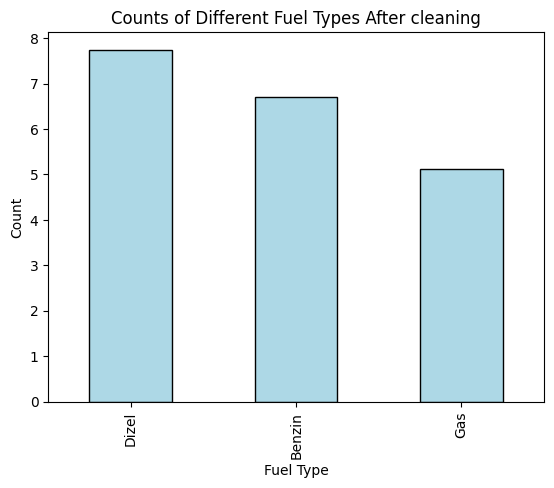

In [101]:
#Prema tipu goriva skup nije balansiran
# print(df['Gorivo'].value_counts())
np.log(df['Gorivo'].value_counts()).plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Counts of Different Fuel Types After cleaning')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.show()

In [102]:
# iz safety features i equipment smo pretrazivali samo koliko imaju iz skupa izabranih
# a ako uopste nema vrednosti nikakve onda stavljamo missing kao broj  --- ostaviti kao jednu od opcija. ---da probamo i da napravimo nove kolone
valid_safety_features = ["Airbag", "Child lock", "ABS", "Blokada motora", "Ulazak bez ključa"]
def count_valid_safety_features(features):
    if pd.notnull(features):  # Check if not NaN
        return sum(1 for feature in features.split(';') if any(valid in feature for valid in valid_safety_features))
    return 'missing'
df['Safety_Feature_Count'] = df['Safety_Features'].apply(count_valid_safety_features)
valid_equipment_features = ["Sportska sedišta", "Tempomat", "Senzori za kišu", "Parking senzori", "Aluminijumske felne", "Multimedija"]
def count_valid_equipment_features(features):
    if pd.notnull(features):  # Check if not NaN
        return sum(1 for feature in features.split(';') if any(valid in feature for valid in valid_equipment_features))
    return 'missing'
df['Equipment_Feature_Count'] = df['Equipment_Features'].apply(count_valid_equipment_features)

df = df.drop('Safety_Features', axis=1)
df = df.drop('Equipment_Features', axis=1)

# print(df[['Safety_Feature_Count', 'Equipment_Feature_Count']])

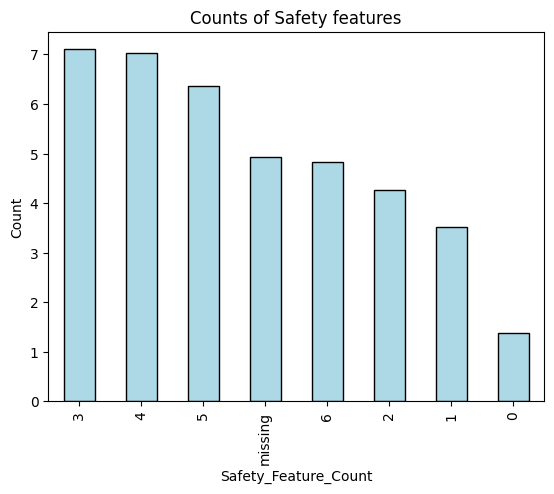

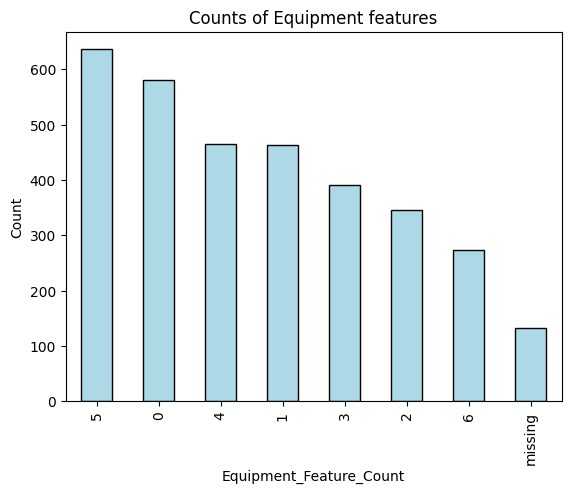

In [103]:
#Nedostajuce vrednosti cemo interpolirati zato sto se radi o nebalansiranom skupu slicnom normalnoj raspodeli
np.log(df['Safety_Feature_Count'].value_counts()).plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Counts of Safety features')
plt.ylabel('Count')
plt.show()

#Ovde je situacija relativno balansirana pa je dovoljno iskoristiti medijanu za popunjavanje nedostajucih vrednosti
df['Equipment_Feature_Count'].value_counts().plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Counts of Equipment features')
plt.ylabel('Count')
plt.show()

In [104]:

# import scipy as sc
df['Safety_Feature_Count'] = pd.to_numeric(df['Safety_Feature_Count'], errors='coerce')

# polinomialna interpolacija
df['Safety_Feature_Count'] = df['Safety_Feature_Count'].interpolate(method='polynomial', order=2).round().clip(upper=6)

# print(df['Safety_Feature_Count'].value_counts())


In [105]:
# Replace 'missing' with NaN for easier handling, when errors='coerce' is set, non-numeric values are converted to NaN instead of raising an error
df['Equipment_Feature_Count'] = pd.to_numeric(df['Equipment_Feature_Count'], errors='coerce')

# Calculate the median of 'Equipment_Feature_Count' excluding 'NaN' values
median_value = df['Equipment_Feature_Count'].median()

# Replace 'NaN' (which represents 'missing') with the calculated median
df['Equipment_Feature_Count'] = df['Equipment_Feature_Count'].fillna(median_value)

# print(df['Equipment_Feature_Count'].value_counts())

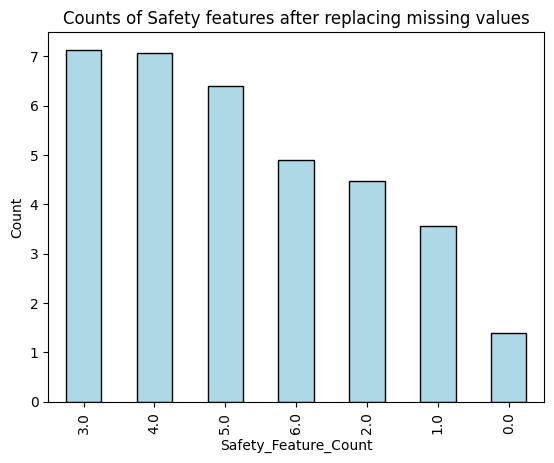

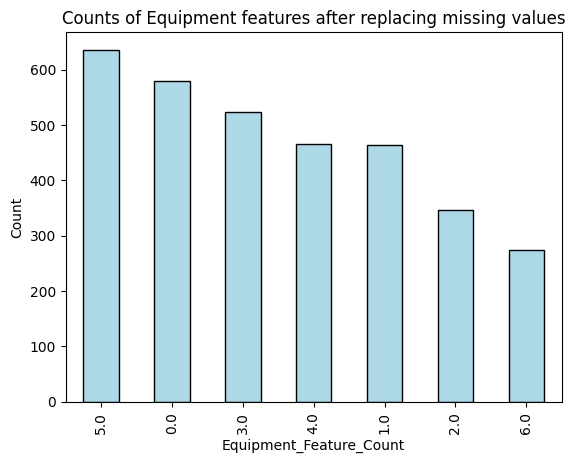

In [106]:
np.log(df['Safety_Feature_Count'].value_counts()).plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Counts of Safety features after replacing missing values')
plt.ylabel('Count')
plt.show()

#Ovde je situacija bila relativno balansirana pa je dovoljno iskoristiti medijanu za popunjavanje nedostajucih vrednosti
df['Equipment_Feature_Count'].value_counts().plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Counts of Equipment features after replacing missing values')
plt.ylabel('Count')
plt.show()

In [107]:
#Posto nedostajucih vrednosti ima oko 500,600 mozemo iskoristiti dodavanje nove kategorije 'nepoznato' za njih
df['Materijal enterijera'] = df['Materijal enterijera'].fillna('Nepoznato')
# print(df['Materijal enterijera'].value_counts())

In [108]:
def clean_currency(value):
    return float(value.replace('€', '').replace('.', '').strip())
def clean_mileage(value):
    return float(value.replace('km', '').replace('.', '').strip())
def clean_engine_volume(value):
    if "cm3" in value:
        return float(value.replace('cm3', '').replace('.', '').strip())
    return value 
def extract_kw(value):
    return float(value.split('/')[0].strip())

df['Cena'] = df['Cena'].apply(clean_currency)
df['Kilometraža'] = df['Kilometraža'].apply(clean_mileage)
df['Snaga motora'] = df['Snaga motora'].apply(extract_kw)
df['Kubikaža'] = df['Kubikaža'].apply(clean_engine_volume)
# print(df)

In [109]:
# izbacivanje duplikata nakon ciscenja podataka (ukoliko se neki sakrio)
df = df.drop_duplicates()

In [110]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

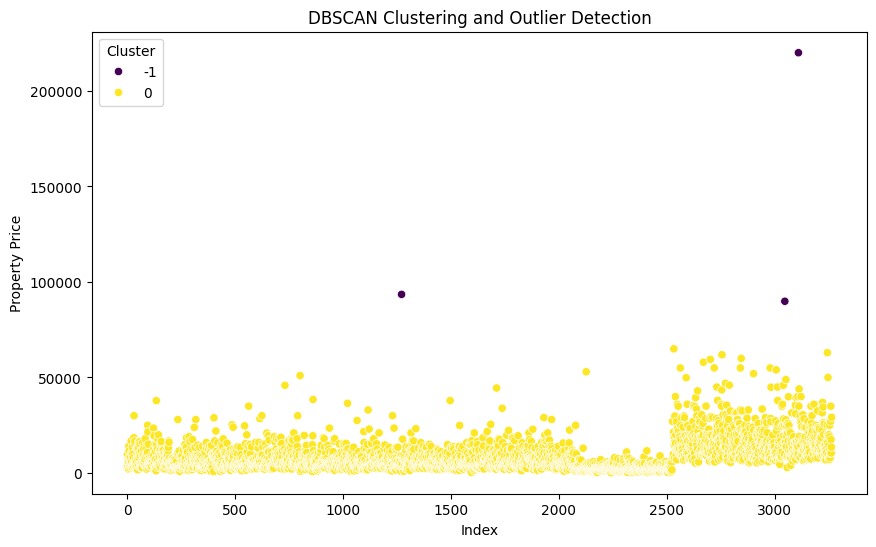

,Cena,Model,Marka,Godište,Kubikaža,Gorivo,Karoserija,Snaga motora,Kilometraža,Oštećenje,Pogon,Klima,Materijal enterijera,Menjač,Broj vrata,Boja,Emisiona klasa motora,Safety_Feature_Count,Equipment_Feature_Count,Cluster
1296,93500.0,S 63 AMG,Mercedes Benz,2015.0,5461.0,Benzin,Kupe,430.0,119983.0,Nije oštećen,4x4,Automatska klima,Kombinovana koža,Automatski / poluautomatski,2/3 vrata,Crna,Euro 6,3.0,6.0,-1
3100,89900.0,G 350,Mercedes Benz,2018.0,2987.0,Dizel,Džip/SUV,180.0,28165.0,Nije oštećen,4x4,Automatska klima,Prirodna koža,Automatski / poluautomatski,4/5 vrata,Zelena,Euro 6,4.0,4.0,-1
3166,220000.0,Urus,Lamborghini,2018.0,3996.0,Benzin,Džip/SUV,478.0,84193.0,Nije oštećen,4x4,Automatska klima,Prirodna koža,Automatski / poluautomatski,4/5 vrata,Siva,Euro 6,4.0,3.0,-1


In [111]:


prices = df[['Cena']].values

# Step 3: Normalize or scale the data (optional, depending on the range of prices)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
prices_scaled = scaler.fit_transform(prices)

# Step 4: Apply DBSCAN
# Adjust eps (radius) and min_samples (minimum points in a cluster) based on your data
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(prices_scaled)

# Step 5: Add DBSCAN labels to the dataframe
df['Cluster'] = labels

# Outliers are labeled as -1 by DBSCAN
outliers = df[df['Cluster'] == -1]

# Step 6: Visualize the results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=range(len(df)), y='Cena', hue='Cluster', palette='viridis')
plt.title('DBSCAN Clustering and Outlier Detection')
plt.xlabel('Index')
plt.ylabel('Property Price')
plt.legend(title='Cluster')
plt.show()
#research question: celija koda pa ima plot i posle plota u jednoj recenici zakljucak.
outliers

In [112]:
# nakon detektovanja outlier-a izbacicemo ih iz skupa
df = df[df['Cluster'] != -1].drop(columns=['Cluster'])

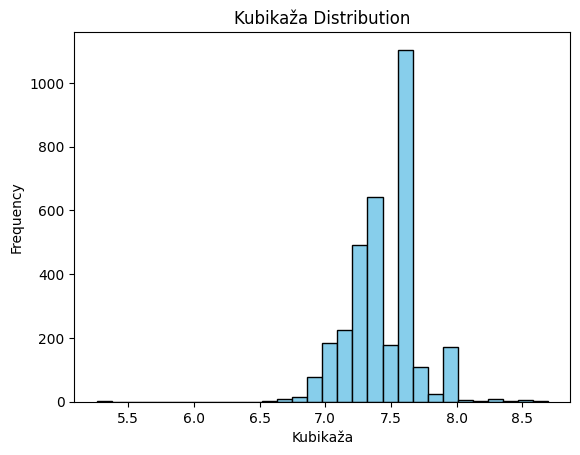

In [113]:
# treba malo pogledati raspodele stvari koje normalizujemo
import matplotlib.pyplot as plt
plt.hist(np.log(df['Kubikaža']), bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Kubikaža')
plt.ylabel('Frequency')
plt.title('Kubikaža Distribution')
plt.show()

# normalizacija velikih kontinualnih vrednosti pomocu standard scaler-a
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df['Kubikaža'] = scaler.fit_transform(df[['Kubikaža']])
df['Kilometraža'] = scaler.fit_transform(df[['Kilometraža']])
df['Snaga motora'] = scaler.fit_transform(df[['Snaga motora']])


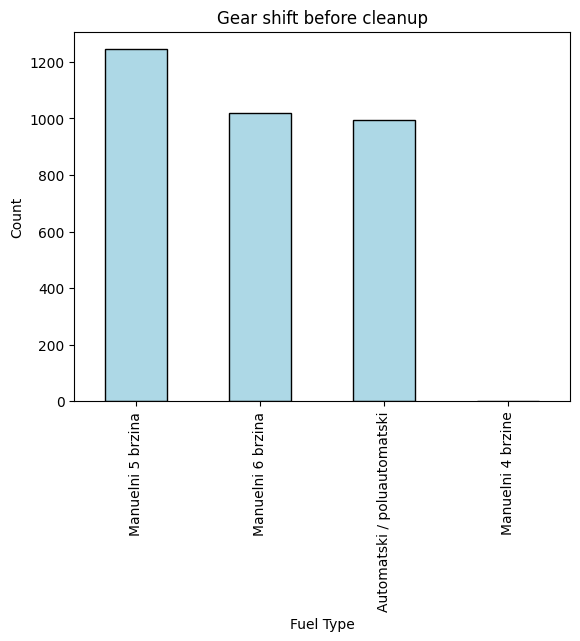

In [114]:
# proveravamo vrednosti za enkodiranje one hotom
df['Menjač'].value_counts().plot(kind='bar', color='lightblue', edgecolor='black') #da logaritmujemo count kad imamo nesrazmijerne grafike
plt.title('Gear shift before cleanup')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.show()

In [115]:
# spajamo sve manuelne u jednu kategoriju
def categorize_gear_shift(value):
    if value == 'Automatski / poluautomatski':
        return 'Automatski'
    elif value in ['Manuelni 5 brzina', 'Manuelni 6 brzina', 'Manuelni 4 brzine']:
        return 'Manuelni'
    else:
        return 'Other'

df['Menjač'] = df['Menjač'].apply(categorize_gear_shift)


In [116]:
# radimo one hot encoding, stvori se nova kolona koja samo ima true false
df = pd.get_dummies(df, columns=['Menjač'], drop_first=True)
df['Menjač_Manuelni'] = df['Menjač_Manuelni'].astype(int)

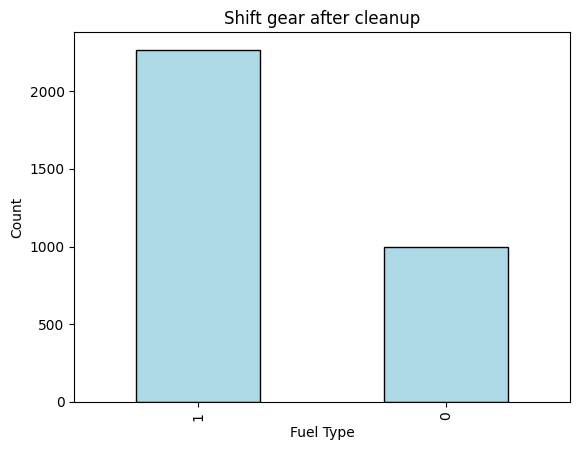

In [117]:
df['Menjač_Manuelni'].value_counts().plot(kind='bar', color='lightblue', edgecolor='black') #da logaritmujemo count kad imamo nesrazmijerne grafike
plt.title('Shift gear after cleanup')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.show()

In [118]:
df['Pogon'].value_counts()

Pogon
Prednji         2383
4x4              505
Zadnji           312
4x4 reduktor      61
Name: count, dtype: int64

In [119]:
def categorize_pogon(value):
    if value == 'Prednji':
        return 'Prednji'
    elif value == 'Zadnji':
        return 'Zadnji'
    elif value in ['4x4', '4x4 reduktor']:
        return '4x4'
    else:
        return 'Other'

df['Pogon'] = df['Pogon'].apply(categorize_pogon)

In [120]:
df['Karoserija'].value_counts()


Karoserija
Hečbek      1353
Limuzina     698
Džip/SUV     567
Karavan      527
Kupe         116
Name: count, dtype: int64

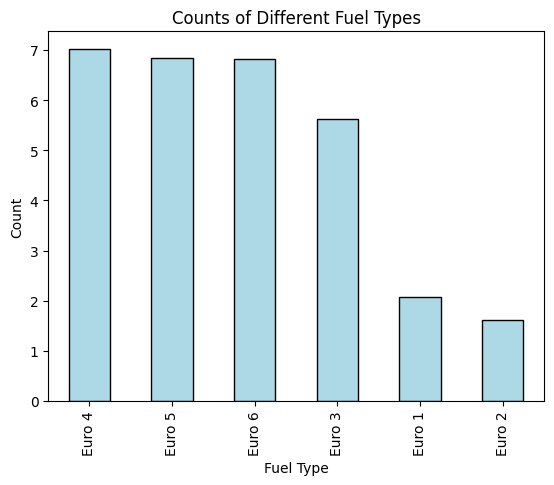

In [121]:
np.log(df['Emisiona klasa motora'].value_counts()).plot(kind='bar', color='lightblue', edgecolor='black') #da logaritmujemo count kad imamo nesrazmijerne grafike
plt.title('Counts of Different Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.show()

#Izbacujemo Euro1 i Euro 2 automobile
df = df[df['Emisiona klasa motora'] != 'Euro 1']
df = df[df['Emisiona klasa motora'] != 'Euro 2']

In [122]:
# label encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['Pogon'] = label_encoder.fit_transform(df['Pogon'])
df['Karoserija'] = label_encoder.fit_transform(df['Karoserija'])
df['Emisiona klasa motora'] = label_encoder.fit_transform(df['Emisiona klasa motora'])
df['Gorivo'] = label_encoder.fit_transform(df['Gorivo'])


In [123]:
df

,Cena,Model,Marka,Godište,Kubikaža,Gorivo,Karoserija,Snaga motora,Kilometraža,Oštećenje,Pogon,Klima,Materijal enterijera,Broj vrata,Boja,Emisiona klasa motora,Safety_Feature_Count,Equipment_Feature_Count,Menjač_Manuelni
0,3200.0,Astra H,Opel,2006.0,-0.156051,1,1,-0.553718,0.624057,Nije oštećen,1,Automatska klima,Nepoznato,4/5 vrata,Plava,1,4.0,2.0,1
1,9500.0,A3,Audi,2013.0,-0.339346,1,1,-0.479255,-0.020582,Nije oštećen,1,Manuelna klima,Štof,4/5 vrata,Crna,2,4.0,4.0,1
2,4000.0,Octavia,Škoda,2008.0,0.281356,1,4,-0.479255,0.518757,Nije oštećen,1,Automatska klima,Štof,4/5 vrata,Crna,1,4.0,1.0,1
3,3300.0,A 180,Mercedes Benz,2008.0,0.479231,1,1,-0.404792,-0.049934,Nije oštećen,1,Manuelna klima,Kombinovana koža,4/5 vrata,Plava,1,4.0,3.0,1
4,3550.0,Corsa D,Opel,2009.0,-1.107933,2,1,-0.926032,0.368513,Nije oštećen,1,Manuelna klima,Štof,4/5 vrata,Crna,1,4.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3323,34990.0,730,BMW,2016.0,2.566288,1,4,2.449617,-0.446491,Nije oštećen,0,Automatska klima,Prirodna koža,4/5 vrata,Crna,3,3.0,5.0,0
3324,17500.0,A4,Audi,2016.0,0.431324,1,4,0.339836,0.082054,Nije oštećen,1,Automatska klima,Štof,4/5 vrata,Crna,2,4.0,5.0,0
3325,10500.0,Golf 7,Volkswagen,2017.0,-0.339346,1,1,-0.752286,0.155529,Nije oštećen,1,Manuelna klima,Štof,4/5 vrata,Bela,3,3.0,5.0,1
3326,13500.0,Superb,Škoda,2017.0,0.497977,1,4,0.339836,-0.534239,Nije oštećen,1,Manuelna klima,Štof,4/5 vrata,Crna,2,3.0,3.0,1


In [124]:
df['Materijal enterijera'].value_counts()

Materijal enterijera
Štof                1753
Nepoznato            512
Prirodna koža        501
Kombinovana koža     396
Drugi                 49
Velur                 37
Name: count, dtype: int64

In [125]:
# EDA
print(df.head())

     Cena    Model          Marka  Godište  Kubikaža  Gorivo  Karoserija  \
0  3200.0  Astra H           Opel   2006.0 -0.156051       1           1   
1  9500.0       A3           Audi   2013.0 -0.339346       1           1   
2  4000.0  Octavia          Škoda   2008.0  0.281356       1           4   
3  3300.0    A 180  Mercedes Benz   2008.0  0.479231       1           1   
4  3550.0  Corsa D           Opel   2009.0 -1.107933       2           1   

   Snaga motora  Kilometraža     Oštećenje  Pogon             Klima  \
0     -0.553718     0.624057  Nije oštećen      1  Automatska klima   
1     -0.479255    -0.020582  Nije oštećen      1    Manuelna klima   
2     -0.479255     0.518757  Nije oštećen      1  Automatska klima   
3     -0.404792    -0.049934  Nije oštećen      1    Manuelna klima   
4     -0.926032     0.368513  Nije oštećen      1    Manuelna klima   

  Materijal enterijera Broj vrata   Boja  Emisiona klasa motora  \
0            Nepoznato  4/5 vrata  Plava         

In [126]:
# da vidimo da li uopste ima kakav uticaj na cenu pa ako ima onda mozemo enkodirati one hot-om ako ne onda izbacimo
# da bismo olaksali analizu zavisnosti između obeležja, sva nenumericka obeležja će biti pretvorena u numerička
#print(df.head()) # obeležja koja treba pretvoriti su model, marka, ostecenje, klima, materijal enterijera, broj vrata
#broj vrata
df['Broj vrata'].value_counts() # dosta nebalansiran skup
df['Cetiri_Vrata'] = (df['Broj vrata'] == '4/5 vrata').astype(int)
df['Cetiri_Vrata'].value_counts()
df = df.drop('Broj vrata', axis=1)

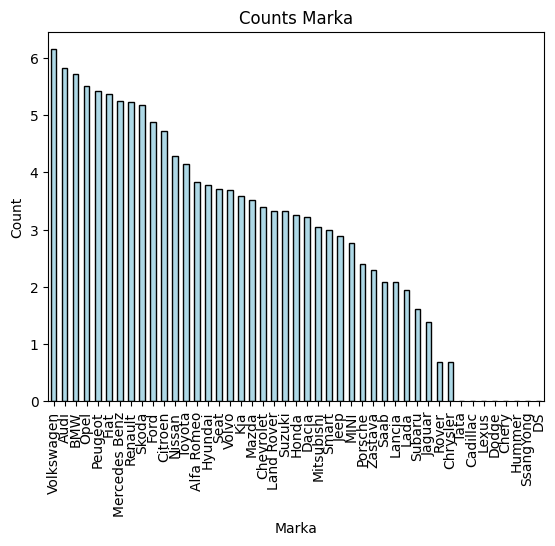

In [127]:

df['Model'].value_counts() # 387 modela automobila ------ previše svakako, ovu kolonu izbacujemo -- ako ne treba mozemo je enkodovati i kao sljedecu metodu
df = df.drop('Model', axis=1)
df['Marka'].value_counts() # 47 marki automobila.
np.log(df['Marka'].value_counts()).plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Counts Marka')
plt.ylabel('Count')
plt.show()

#veliki broj klasa, koristićemo frequent encoding ---- bas zato sto je nebalansiran skup, mijenja se kategorija sa brojem pojavljivanja u skupu
frequency_map = df['Marka'].value_counts(normalize=True)
df['Marka'] = df['Marka'].map(frequency_map)


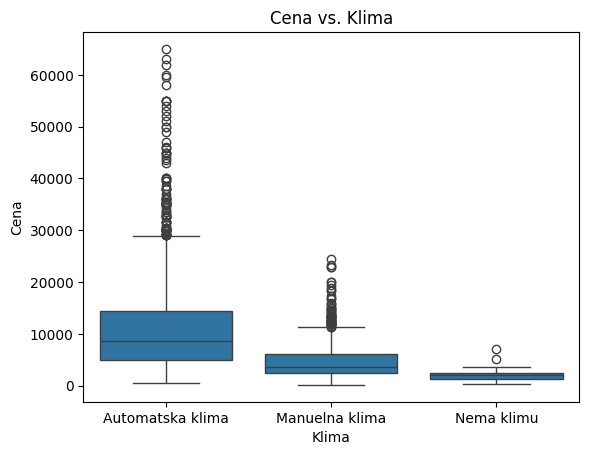

In [128]:
# izbacicemo ove sto nemaju najveovatnije a onda one hot encoding
df['Klima'].value_counts()
sns.boxplot(x='Klima', y='Cena', data=df)
plt.title('Cena vs. Klima')
plt.show()
# na osnovu plota vidim da imamo dosta autlajera


In [129]:
df['Klima'].value_counts()

Klima
Automatska klima    2146
Manuelna klima      1044
Nema klimu            58
Name: count, dtype: int64

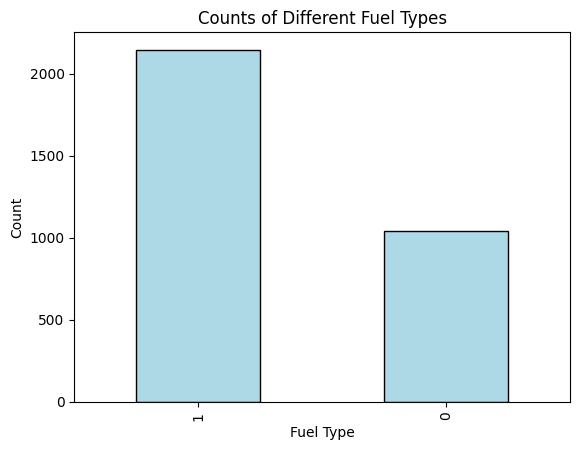

In [130]:
df = df[df['Klima'] != "Nema klimu"] #TODO: provjeriti da li izbaciti ovo
#one hot encoding
#df = pd.get_dummies(df, columns=['Klima'], drop_first=True)
df['Klima'].value_counts()
# one hot encoding 
df['Automatska_Klima'] = (df['Klima'] == 'Automatska klima').astype(int)
df = df.drop('Klima', axis = 1)
df['Automatska_Klima'].value_counts().plot(kind='bar', color='lightblue', edgecolor='black') #da logaritmujemo count kad imamo nesrazmijerne grafike
plt.title('Counts of Different Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.show()

In [131]:
# jako nebalansirano, ostecenje utice na cenu, izbacicemo ostecena auta!
df['Oštećenje'].value_counts()

#provera kako ostecenje utice na cenu -- korisitmo tzv analizu varianse (Analysis of variance) tj. koliko srednja vrednost cene se menja kroy kategorije

# from scipy.stats import f_oneway
# #rucno je da znamo na koje se klase odnosi
# groups = [df['Cena'][df['Oštećenje'] == cat] for cat in df['Oštećenje'].unique()]
# f_stat, p_val = f_oneway(*groups)

# print(f'F-statistic: {f_stat}, p-value: {p_val}')


Oštećenje
Nije oštećen                      3125
Oštećen - u voznom stanju           43
Oštećen - nije u voznom stanju      22
Name: count, dtype: int64

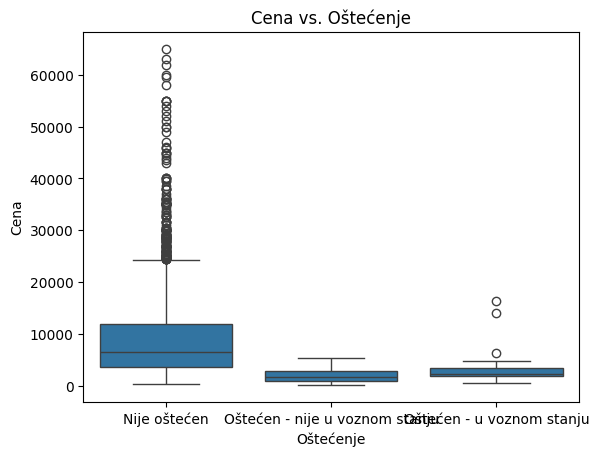

In [132]:
"""
Ovo prebaciti u eda notebook kako ostecenje utice na cenu
"""
sns.boxplot(x='Oštećenje', y='Cena', data=df)
plt.title('Cena vs. Oštećenje')
plt.show()


In [133]:
# plotovi stecenih su mnogo manji u odnosu na  one koji nije ostecen. Takodje, vidimo da imamo dosta autlajera u neostecenim.
# vidimo da ostecene mozemo izbaciti -- previse su velike oscilacije u ceni. mnogo uticu na cenu.
#izbacujemo automobile koji su osteceni i uklonicemo ovo polje jer ce biti identicno za svaki podatak
df = df[df['Oštećenje'] == 'Nije oštećen']
#df['Oštećenje'].value_counts()
df = df.drop('Oštećenje', axis=1)

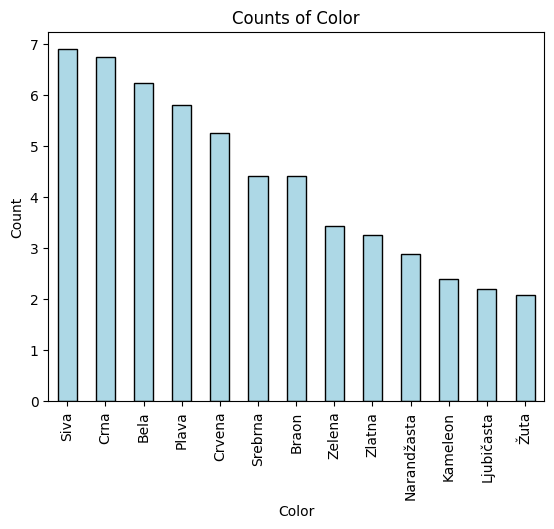

In [134]:

# Bež, krem i smeđu ćemo spojiti sa braon. bordo spajamo sa crvenom. Tirkiz i teget se spaja sa plavom.
df['Boja'] = df['Boja'].replace('Bordo', 'Crvena')
df['Boja'] = df['Boja'].replace('Tirkiz', 'Plava')
df['Boja'] = df['Boja'].replace('Teget', 'Plava')
df['Boja'] = df['Boja'].replace('Krem', 'Braon')
df['Boja'] = df['Boja'].replace('Bež', 'Braon')
df['Boja'] = df['Boja'].replace('Smeđa', 'Braon')
np.log(df['Boja'].value_counts()).plot(kind='bar', color='lightblue', edgecolor='black') #da logaritmujemo count kad imamo nesrazmijerne grafike
plt.title('Counts of Color')
plt.xlabel('Color')
plt.ylabel('Count')
plt.show()

In [135]:
"""
TODO: vidjeti da li ovo da izbacimo ove boje ili ne
"""
removing_colors = ['Žuta','Ljubičasta','Kameleon'] #vidjeti da li da izbacimo ove boje
mask = ~df['Boja'].isin(removing_colors)
df = df[mask]
df['Boja'].value_counts()
print(df.shape[0])

# label encoding. Zbog borja klasa razmisliti o feature encodingu
df['Boja'] = label_encoder.fit_transform(df['Boja'])


3097


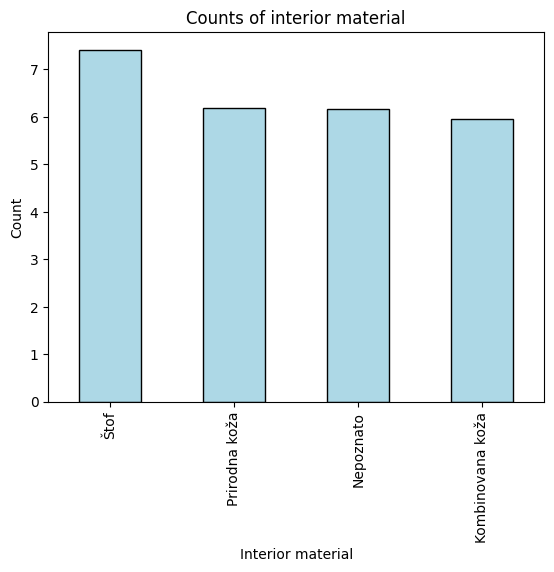

In [137]:
np.log(df['Materijal enterijera'].value_counts()).plot(kind='bar', color='lightblue', edgecolor='black') #da logaritmujemo count kad imamo nesrazmijerne grafike
plt.title('Counts of interior material')
plt.xlabel('Interior material')
plt.ylabel('Count')
plt.show() #necemo izbacivati
# removing_materials = ['Drugi','Velur']
# mask1 = ~df['Materijal enterijera'].isin(removing_materials)
# df = df[mask1]


In [138]:
# label encoding. Zbog borja klasa razmisliti o feature encodingu
df['Materijal enterijera'] = label_encoder.fit_transform(df['Materijal enterijera'])
print(df)

         Cena     Marka  Godište  Kubikaža  Gorivo  Karoserija  Snaga motora  \
0      3200.0  0.075431   2006.0 -0.156051       1           1     -0.553718   
1      9500.0  0.104680   2013.0 -0.339346       1           1     -0.479255   
2      4000.0  0.054803   2008.0  0.281356       1           4     -0.479255   
3      3300.0  0.058805   2008.0  0.479231       1           1     -0.404792   
4      3550.0  0.075431   2009.0 -1.107933       2           1     -0.926032   
...       ...       ...      ...       ...     ...         ...           ...   
3323  34990.0  0.093288   2016.0  2.566288       1           4      2.449617   
3324  17500.0  0.104680   2016.0  0.431324       1           4      0.339836   
3325  10500.0  0.143781   2017.0 -0.339346       1           1     -0.752286   
3326  13500.0  0.054803   2017.0  0.497977       1           4      0.339836   
3327  29200.0  0.008621   2017.0  0.495894       1           0      0.885897   

      Kilometraža  Pogon  Materijal ent

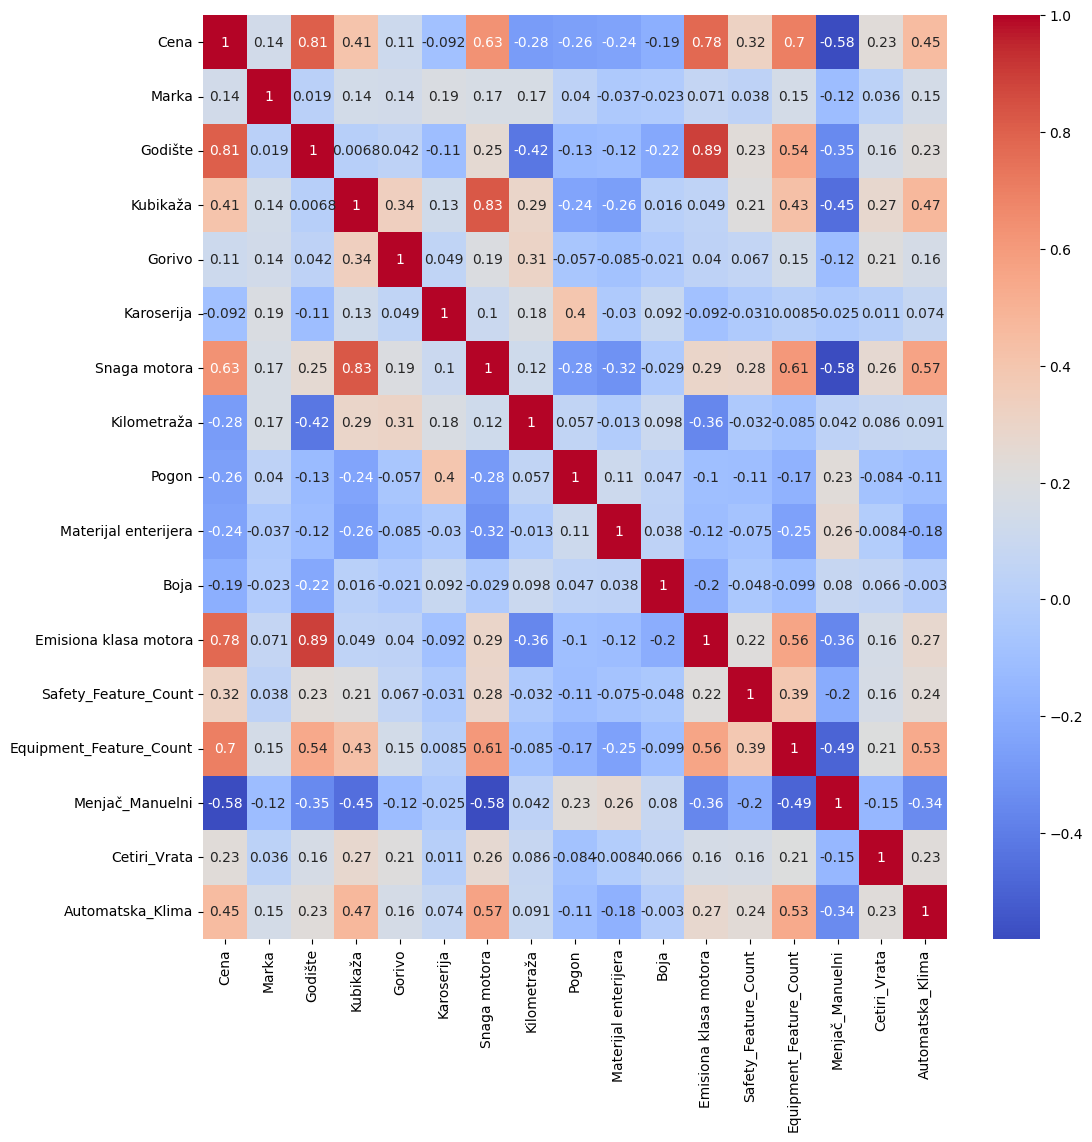

In [139]:
# racunanje korelacione matrice, ----- gledamo samo linearnu zavisnost ovdje
#yasto spearman a ne default pearson? -- jer je nas dataset poprilicno nebalansiran

correlation_matrix = df.corr(method = 'spearman',numeric_only=True)
# print(correlation_matrix)

# vizualiyacija pomocu heatmap-e
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


In [140]:
# Na osnovu heatmap-e , može se zaključiti sljedeće 
#1,00 predstavlja perfektnu pozitivnu koleraciju.
#Godište i emisiona klasa motora imaju 0,89 zavisnost
#Takođe Kubikaža i snaga motora imaju korelaciju 0,81.
#karoserija ima jako mali koeficijent korelacije.

#postavljaćemo pitanja u EDI koja su vezana za ovo


In [53]:
# df = df.drop('Karoserija', axis = 1)
# df = df.drop('Emisiona klasa motora', axis=1)
# df = df.drop('Snaga motora', axis=1)

In [141]:
print(df.shape)

(3018, 17)


In [142]:
df['Godište'] = scaler.fit_transform(df[['Godište']]) # previse smo stvari izbacili.
# imamo minimalno eksplorativne analize. cena po marki automobila. kako se ponasa cena spram kubikaze. pearsonovu korelaciju i da plotujemo.
#eksplorativna analiza za cijene telefona kao primjer. koja su to zanimljiva pitanja koja treba postaviti.
#da notebook prolazi kroz desetak research pitanja. Neka su bila povezana za ciscenje podataka.
# maks 5 minuta da se moze ispricati. zaposleni primjer na kanvasu.

In [143]:
df.to_csv('sredjeni.csv',index=False)